# Optimizing Model - Creating Average Departure and Arrival Delays

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
data_flight_info = pd.read_csv('/Users/craiglynch/Desktop/Lighthouse_Labs/Mid-term_Project/mid-term-project-I-master/Regression_no_outliers_cleaned_data_01.csv', sep = ',')

In [3]:
df_flight_info = data_flight_info.copy()

In [4]:
df_flight_info.tail()

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year,month,day,weekday
578883,2019-04-12,AS,AS,1039,LAS,600,558.0,-2.0,SEA,915.0,...,867.0,0.0,0.0,25.0,0.0,0.0,2019,4,12,0.0
578884,2019-03-27,UA,OO,5744,LAX,2240,2307.0,27.0,SBA,4.0,...,89.0,0.0,0.0,2.0,0.0,27.0,2019,3,27,0.0
578885,2018-08-13,AA,AA,588,LGA,559,558.0,-1.0,PHL,714.0,...,96.0,0.0,0.0,0.0,0.0,0.0,2018,8,13,0.0
578886,2018-07-13,UA,UA,1027,ORD,1425,1421.0,-4.0,CHS,1744.0,...,760.0,0.0,0.0,0.0,0.0,0.0,2018,7,13,0.0
578887,2018-02-23,AA,OO,3099,ORD,950,946.0,-4.0,CID,1104.0,...,196.0,0.0,0.0,0.0,0.0,0.0,2018,2,23,0.0


In [5]:
## Grouping Delays

# Finding average route times
df_flight_info['flight_number'] = df_flight_info['op_unique_carrier'] + df_flight_info['op_carrier_fl_num'].astype(str)
route_time_grouped = df_flight_info.groupby(by='flight_number').mean()
route_time_grouped.reset_index(inplace=True)
route_time_grouped['average_route_time'] = route_time_grouped['actual_elapsed_time']
route_time_grouped = route_time_grouped[['flight_number','average_route_time']]

In [6]:
# Getting Average Carrier Delay - Grouped by Carrier
carrier_grouped = df_flight_info.groupby(by='op_unique_carrier').mean()
carrier_grouped.reset_index(inplace=True)
carrier_grouped['total_carrier_delay'] = carrier_grouped['carrier_delay'] + carrier_grouped['late_aircraft_delay']
carrier_grouped = carrier_grouped[['op_unique_carrier', 'total_carrier_delay']]

In [7]:
# Getting Average NAS Delay - Grouped by Flight Number
nas_grouped = df_flight_info.groupby(by='flight_number').mean()
nas_grouped.reset_index(inplace=True)
nas_grouped['total_nas_delay'] = nas_grouped['nas_delay']
nas_grouped = nas_grouped[['flight_number', 'total_nas_delay']]


# Getting Average Security Delay
security_grouped = df_flight_info.groupby(by='origin').mean()
security_grouped.reset_index(inplace=True)
security_grouped['total_security_delay'] = security_grouped['security_delay']
security_grouped = security_grouped[['origin','total_security_delay']]

# Getting Average Departure Delays by Route
dep_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
dep_delay_grouped.reset_index(inplace=True)
dep_delay_grouped['total_dep_delay'] = dep_delay_grouped['dep_delay']
dep_delay_grouped = dep_delay_grouped[['flight_number','total_dep_delay']]

# Getting Average Arrival Delays by Route
arr_delay_grouped = df_flight_info.groupby(by='flight_number').mean()
arr_delay_grouped.reset_index(inplace=True)
arr_delay_grouped['total_arr_delay'] = arr_delay_grouped['arr_delay']
arr_delay_grouped = arr_delay_grouped[['flight_number','total_arr_delay']]

#Merge averages dataframes with original 
df_flight_info = df_flight_info.merge(security_grouped, on = 'origin', how = 'outer')
df_flight_info = df_flight_info.merge(nas_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(route_time_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(dep_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(arr_delay_grouped, on = 'flight_number', how = 'outer')
df_flight_info = df_flight_info.merge(carrier_grouped, on = 'op_unique_carrier', how = 'outer')

## Model Training

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, r2_score, f1_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [9]:
df_flight_info["flight_number"] = df_flight_info["flight_number"].astype('category').cat.codes

In [10]:
df_flight_info.head(1)

,fl_date,mkt_unique_carrier,op_unique_carrier,op_carrier_fl_num,origin,crs_dep_time,dep_time,dep_delay,dest,arr_time,...,month,day,weekday,flight_number,total_security_delay,total_nas_delay,average_route_time,total_dep_delay,total_arr_delay,total_carrier_delay
0,2018-03-06,B6,B6,112,ORD,2033,2016.0,-17.0,BOS,2340.0,...,3,6,0.0,5279,0.003733,7.275,138.575,50.375,49.575,14.943584


In [11]:
df_flight_info = shuffle(df_flight_info)
X = df_flight_info[['crs_dep_time','flight_number','crs_elapsed_time','average_route_time','crs_arr_time','distance','total_carrier_delay', 'total_security_delay','total_nas_delay','total_dep_delay','total_arr_delay']]
y = df_flight_info['arr_delay']

In [12]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

##### LightGBM

In [13]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.08
params['boosting_type'] = 'gbdt'
#params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 5
params['max_depth'] = 100
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, results)))
print('Model R2 Score is: ',r2_score(y_test,results))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 405221, number of used features: 11
[LightGBM] [Info] Start training from score 5.672739
Model RMSE is:  41.82861365354711
Model R2 Score is:  0.059091924953348585


##### XGBoost

In [14]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_test,y_test)

y_pred_xgb = xg_reg.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_xgb))

Model RMSE is:  41.98796513676649
Model R2 Score is:  0.05190924865936031


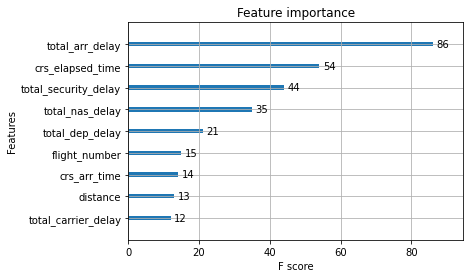

In [15]:
#Examine the importance of each feature column in the original data set with the model
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

##### Linear Regression

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# creating linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_lr)))
print('Model R2 Score is: ',r2_score(y_test,y_lr))

Model RMSE is:  41.56632064254555
Model R2 Score is:  0.07466120377383412


##### Ridge/Lasso Regression

In [17]:
ridgereg = Ridge(alpha=0.001,normalize=True)
ridge = ridgereg.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_ridge))

lassoreg = Lasso(alpha=0.001,normalize=True)
lasso = lassoreg.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print('Model R2 Score is: ',r2_score(y_test,y_pred_lasso))

Model RMSE is:  41.566493059263536
Model R2 Score is:  0.07465352716417994
Model RMSE is:  41.58361230626475
Model R2 Score is:  0.07389115844905081


##### Random Forest

In [18]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators=100)

In [19]:
#Train the model using the training sets 
clf.fit(X_train,y_train)

RandomForestRegressor()

In [20]:
y_pred=clf.predict(X_test)

In [21]:
print('Model RMSE is: ',np.sqrt(mean_squared_error(y_test, y_pred)))
print('Model R2 Score is: ',r2_score(y_test,y_pred))

Model RMSE is:  48.19745755730411
Model R2 Score is:  -0.20881541977450402
